# kNN Model Training using Cross-Validation, and Evaluation on Test Datasets

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Load CV and Model Training Data

In [2]:
# Cross validation/training dataset
cv_set = pd.read_csv('data/training.csv')

In [3]:
# Features to use
feature_cols = 'axdt_var,aydt_var,gzdt_var'.split(',')

In [4]:
cv_set.head()

,motion_state,adt_sum,gdt_sum,axdt_var,aydt_var,azdt_var,gxdt_var,gydt_var,gzdt_var,adt_var,gdt_var,adt_min,gdt_min,adt_max,gdt_max
0,straight,9.498792,0.008515,0.000004,0.000001,0.000006,3.856139e-09,2.467973e-09,1.958251e-09,0.000006,1.076465e-09,0.093785,0.000026,0.101785,0.000171
1,straight,9.799902,0.008413,0.000004,0.000001,0.000007,3.463234e-09,2.769963e-09,1.785013e-09,0.000006,1.299795e-09,0.094010,0.000015,0.101634,0.000167
2,rest,9.792245,0.009893,0.000004,0.000001,0.000007,3.881253e-09,3.281482e-09,3.870479e-09,0.000007,1.794662e-09,0.093513,0.000010,0.101982,0.000219
3,rest,9.796759,0.009319,0.000004,0.000001,0.000008,3.439800e-09,3.309496e-09,2.681825e-09,0.000008,1.547565e-09,0.093461,0.000017,0.102362,0.000206
4,straight,9.806574,0.009778,0.000003,0.000008,0.000006,5.623301e-09,2.478434e-09,2.738851e-09,0.000006,1.621392e-09,0.093818,0.000032,0.102166,0.000213


In [5]:
# Target vector 
y = cv_set['motion_state'].copy()
y.head()


0    straight
1    straight
2        rest
3        rest
4    straight
Name: motion_state, dtype: object

In [6]:
# Featureset
X = cv_set[feature_cols]
X.head()

,axdt_var,aydt_var,gzdt_var
0,0.000004,0.000001,1.958251e-09
1,0.000004,0.000001,1.785013e-09
2,0.000004,0.000001,3.870479e-09
3,0.000004,0.000001,2.681825e-09
4,0.000003,0.000008,2.738851e-09


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   axdt_var  259 non-null    float64
 1   aydt_var  259 non-null    float64
 2   gzdt_var  259 non-null    float64
dtypes: float64(3)
memory usage: 6.2 KB


In [8]:
print(f"X is of type {type(X)} and size {X.shape}")
print(f"y is of type {type(y)} and size {y.shape}")

X is of type <class 'pandas.core.frame.DataFrame'> and size (259, 3)
y is of type <class 'pandas.core.series.Series'> and size (259,)


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [10]:
# Train(CV)-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [11]:
# Cross Validation grid definition
param_grid = [
                {
                'classifier': [KNeighborsClassifier()],
                'preprocessing': [RobustScaler(), MinMaxScaler(), StandardScaler(), None],
                'classifier__n_neighbors': [2, 4, 6, 8, 12, 20],                
                }
]

In [12]:
# Pipeline for gridCV
pipe = Pipeline([('preprocessing',RobustScaler()), ('classifier',KNeighborsClassifier())])

In [13]:
# Perform grid search to find best model params
grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', RobustScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid=[{'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [2, 4, 6, 8, 12, 20],
                          'preprocessing': [RobustScaler(), MinMaxScaler(),
                                            StandardScaler(), None]}],
             return_train_score=True)

In [14]:
# Results of grid search
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation train score: {:.2f}".format(grid.cv_results_['mean_train_score'][grid.best_index_]))
print("Best cross-validation validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 12, 'preprocessing': RobustScaler()}

Best cross-validation train score: 0.81
Best cross-validation validation score: 0.80
Test-set score: 0.81


Insignificant gap between train/validation/test scores, indicating model cannot be tuned further. Score in the 0.80's indicate the model complexity is not high enough. 

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_classification(true_values, predicted_values, ticklabels, model):
    # Calculate confusion matrix
    confusion_mat = confusion_matrix(true_values, predicted_values)
    
    # Plot heatmap
    sns.heatmap(confusion_mat, xticklabels=ticklabels, yticklabels=ticklabels, annot=True, fmt='d', cbar=False, cmap='viridis')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Confusion Matrix - ' + model)
    plt.show()

    # Calculate scores
    accuracy = accuracy_score(true_values, predicted_values)
    precision = precision_score(true_values, predicted_values, average='macro')
    recall = recall_score(true_values, predicted_values, average='macro')
    f1 = f1_score(true_values, predicted_values, average='macro')

    '''# Calculate additional metrics
    tn, fp, fn, tp = confusion_mat.ravel()

    # Print additional metrics
    print("Metrics for", model)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)
    print("True Positives:", tp)'''

    # Print classification report
    print("\nClassification Report for", model + ":")
    print(classification_report(true_values, predicted_values))

    # Print scores
    print("\nAccuracy Score:", accuracy)
    print("Precision Score:", precision)
    print("Recall Score:", recall)
    print("F1 Score:", f1)   

### Detailed classification evaluation on test split from CV datset

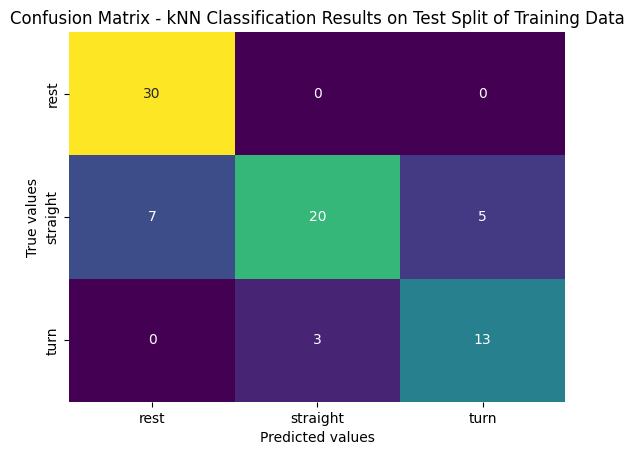


Classification Report for kNN Classification Results on Test Split of Training Data:
              precision    recall  f1-score   support

        rest       0.81      1.00      0.90        30
    straight       0.87      0.62      0.73        32
        turn       0.72      0.81      0.76        16

    accuracy                           0.81        78
   macro avg       0.80      0.81      0.80        78
weighted avg       0.82      0.81      0.80        78


Accuracy Score: 0.8076923076923077
Precision Score: 0.8008660834747792
Recall Score: 0.8125
F1 Score: 0.7958336658951234


In [16]:
evaluate_classification(y_test, grid.predict(X_test), ['rest', 'straight','turn'], 'kNN Classification Results on Test Split of Training Data')

Overall good results, however, straight driving tends to be misclassified more often than the other two. 

## Model Performance Test based on Two Independent Datasets

### First test dataset

In [17]:
test_set1 = pd.read_csv('data/testing.csv')
test_set1.head()

,motion_state,adt_sum,gdt_sum,axdt_var,aydt_var,azdt_var,gxdt_var,gydt_var,gzdt_var,adt_var,gdt_var,adt_min,gdt_min,adt_max,gdt_max
0,rest,4.602953,0.004064,0.000006,0.000003,0.000012,4.162347e-09,2.158534e-09,1.662997e-09,0.000012,1.818951e-09,0.093153,0.000020,0.102891,0.000189
1,rest,9.795434,0.008478,0.000005,0.000002,0.000008,3.614823e-09,2.118414e-09,2.392751e-09,0.000008,1.380667e-09,0.093168,0.000013,0.102563,0.000162
2,straight,9.793045,0.008932,0.000004,0.000001,0.000007,3.623142e-09,2.669124e-09,2.515259e-09,0.000007,1.120863e-09,0.093440,0.000033,0.102174,0.000179
3,straight,9.808845,0.009974,0.000004,0.000021,0.000009,6.206409e-09,2.755071e-09,2.981368e-09,0.000009,2.348890e-09,0.092092,0.000014,0.103117,0.000243
4,turn,9.880517,0.030474,0.000006,0.000014,0.000003,9.496197e-09,8.561489e-09,1.525361e-08,0.000003,1.464841e-08,0.094830,0.000055,0.103888,0.000521


In [18]:
y2 = test_set1['motion_state'].copy()
X2 = test_set1[feature_cols].copy()
X2.head()

,axdt_var,aydt_var,gzdt_var
0,0.000006,0.000003,1.662997e-09
1,0.000005,0.000002,2.392751e-09
2,0.000004,0.000001,2.515259e-09
3,0.000004,0.000021,2.981368e-09
4,0.000006,0.000014,1.525361e-08


In [19]:
y2.head()

0        rest
1        rest
2    straight
3    straight
4        turn
Name: motion_state, dtype: object

In [20]:
# Evaluate the accuracy of the first dataset 
print("Test-set score: {:.2f}".format(grid.score(X2, y2)))

Test-set score: 0.89


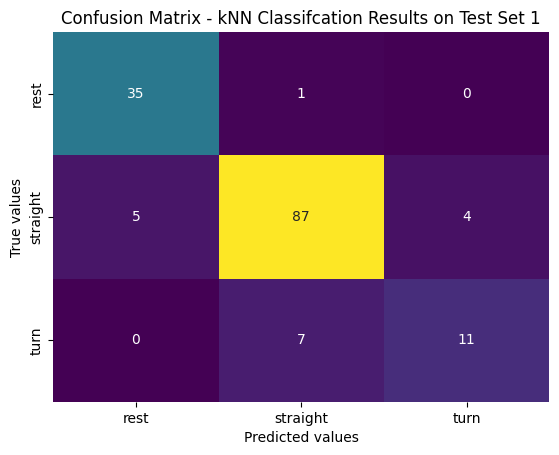


Classification Report for kNN Classifcation Results on Test Set 1:
              precision    recall  f1-score   support

        rest       0.88      0.97      0.92        36
    straight       0.92      0.91      0.91        96
        turn       0.73      0.61      0.67        18

    accuracy                           0.89       150
   macro avg       0.84      0.83      0.83       150
weighted avg       0.88      0.89      0.88       150


Accuracy Score: 0.8866666666666667
Precision Score: 0.8413742690058479
Recall Score: 0.8298611111111112
F1 Score: 0.83290468754784


In [21]:
evaluate_classification(y2, grid.predict(X2), ['rest', 'straight','turn'], 'kNN Classifcation Results on Test Set 1')

Data set shows great imbalance. Straight versus rest shows great performance, however, almost one third of the turns are misclassified as straight.

### Second test dataset

In [22]:
test_set2 = pd.read_csv('data/testing2.csv')
test_set2.head()

,motion_state,adt_sum,gdt_sum,axdt_var,aydt_var,azdt_var,gxdt_var,gydt_var,gzdt_var,adt_var,gdt_var,adt_min,gdt_min,adt_max,gdt_max
0,rest,2.545991,0.003137,2.620811e-07,0.000002,2.229108e-07,5.920816e-09,3.321791e-09,5.625258e-09,2.209511e-07,2.283056e-09,0.096978,0.000040,0.098823,0.000241
1,rest,9.791828,0.011956,2.337172e-07,0.000002,1.875037e-07,7.127246e-09,4.748617e-09,4.005550e-09,1.906057e-07,2.450247e-09,0.096799,0.000039,0.099082,0.000271
2,rest,9.791926,0.012479,2.776219e-07,0.000002,9.885091e-08,8.415966e-09,3.900123e-09,4.623897e-09,9.991127e-08,2.849623e-09,0.097155,0.000027,0.098707,0.000302
3,rest,9.793009,0.011842,2.813144e-07,0.000002,8.021861e-08,8.668215e-09,3.261839e-09,3.373985e-09,8.170654e-08,2.743603e-09,0.097284,0.000012,0.098749,0.000275
4,rest,9.791697,0.011758,3.282090e-07,0.000002,1.095458e-07,6.701061e-09,4.993413e-09,4.006629e-09,1.070334e-07,3.224875e-09,0.097299,0.000008,0.099036,0.000269


In [23]:
y3 = test_set2['motion_state'].copy()
X3 = test_set2[feature_cols]

In [24]:
print("Test-set score: {:.2f}".format(grid.score(X3, y3)))

Test-set score: 0.86


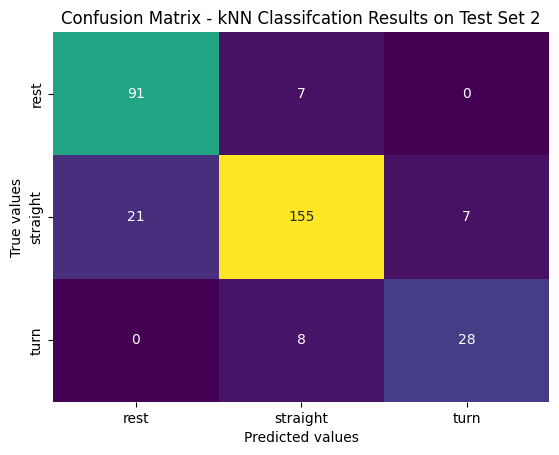


Classification Report for kNN Classifcation Results on Test Set 2:
              precision    recall  f1-score   support

        rest       0.81      0.93      0.87        98
    straight       0.91      0.85      0.88       183
        turn       0.80      0.78      0.79        36

    accuracy                           0.86       317
   macro avg       0.84      0.85      0.84       317
weighted avg       0.87      0.86      0.86       317


Accuracy Score: 0.8643533123028391
Precision Score: 0.841421568627451
Recall Score: 0.8511145806227773
F1 Score: 0.8445286766237969


In [25]:
evaluate_classification(y3, grid.predict(X3), ['rest', 'straight','turn'], 'kNN Classifcation Results on Test Set 2')

Results comparable to test split from training data, straight driving has the most misclasification. Dataset imbalance is even more exaggerated. 